<a href="https://colab.research.google.com/github/TOM-BOHN/Customer-Success-Scorecards/blob/main/marketing_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Marketing Text Classification
**Thomas Bohn**   --   **2023-09-12**

A report focused on modeling news article categorization for marketing analytics. This notebook focuses on the application of natural language processing, supervised learning with [k-train](https://github.com/amaiya/ktrain) (a wrapper for [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/all_symbols), [Keras](https://keras.io/getting_started/), and [Huggingface Transformers](https://github.com/huggingface/transformers)), and a evaluation of performance.

--  [Main Report](https://github.com/TOM-BOHN/Customer-Success-Scorecards/blob/main/marketing_text_classification.ipynb)  --  [Github Repo](https://github.com/TOM-BOHN/MsDS-marketing-text-classification)  --  [Presentation Slides](TBD)  --  [Presentation Video](TBD) --

# 1.&nbsp;Introduction

**Context**
A media buying company has acquired a new customer [Theragun](https://www.therabody.com/us/en-us/4th-generation-devices/), a company developing wellness products backed by science and developed by medical experts. Theragun knows that consumers who value health and wellness are more likely to consider, and ultimately buy their product. They have requested their media buying company partner identify as many news articles around the web that mention health and wellness. Their goal is to feature advertisements on these pages to reach as many customers as possible.

**Background**
Text and text documents are one of the richest sources of data for businesses. They are websites, pdfs, news articles, etc. A strategy utilized by marketing firms is contextual advertising. It focused on using marketing analytics to find URLs that match the context required to target an advertisement to potential customers. The main challenge is to build an algorithm that successfully predicts the probability that a website is related to the desired context. The final trained model can be used to identify tags for untracked websites or to identify the type of language used in different websites.

**Data Source**
The dataset contains around 200k news headlines from the year 2012 to 2018 obtained from [HuffPost](https://www.huffpost.com/). It can be sourced [here](https://drive.google.com/file/d/1jnucfZWLPmxG4UzPtgd-dRe_Z9tPo60V/view?usp=sharing).

**Categories**
Each news headline has a corresponding category. The articles are labeled under one of ??? categories. A sample of the categories is as follows:
- WELLNESS: 17827
- HEALTHY LIVING: 6694
- ...
- POLITICS: 32739
- TECH: 2082

**Overview of Observations**
The dataset is broken into 1490 records for training and 735 for testing. Each observation is the full text of the article with an associated article id [1]. The text files need to be broaken out into features. The training dataset indicates the category. No category is provided for the test dataset.

**Objective**
The objective is to build a deep learning algorithm that predicts the probability that a news story is about health and wellness. Final evaluation will use Sensativity (also known as "Recall") to maximize the number of targeted news articles. Sensativity is the percent of cases where the model prediction is correct, when the actual value is positive.

**Report Overview**
The project will cover 5 key phases:
1. Exploratory Data Analysis (EDA)
2. Data Cleaning
3. Extracting Word Features with Natural Language Processing (NLP) Tools
4. Building and Training an Unsupervised Non-Negative Matrix Factorization (NMF) Model
5. Build and Compare a Random Forest Supervised Learning Model

## Python Libraries

The following python libraries are used in this notebook.

In [1]:
# File Connection and File Manipulation
import os
import time
import pickle
import json
import glob
# Basic Data Science Toolkits
import pandas as pd
import numpy as np
import math
import time
# Basic Data Vizualization
import seaborn as sns
import matplotlib.pyplot as plt
# Import Data Model Evaluations
from sklearn.model_selection import train_test_split
from sklearn import metrics
# NLP Tokenizer
from keras.preprocessing.text import Tokenizer
# Google's Tensorflow package
# https://www.tensorflow.org/tutorials
import tensorflow as tf
print(tf.__version__)
# API wrapper for Tensorflow called ktrain
# https://github.com/amaiya/ktrain
try:
  import ktrain
except:
  !pip install ktrain
  os.kill(os.getpid(), 9)
from ktrain import text
from ktrain.text import texts_from_df
#NLP Text Cleanup
import re
import nltk
import nltk.corpus
from nltk.corpus import stopwords

# NLP Tokenizer and Lemmatizer
import nltk
import nltk.corpus
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import digits

2.13.0


## Installing NLTK Data

In [2]:
#Install the necessary datasets/models for specific functions to work
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('brown')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [3]:
# Test to confirm the download worked
from nltk.corpus import brown
brown.words()
#dir(nltk)

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', ...]

## Verify GPU Runtime

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Sep 12 17:43:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Mount Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setup Directories

In [6]:
ROOT_DIR = "/content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/1_text_classification"
DATA_DIR = "%s/data" % ROOT_DIR
EVAL_DIR = "%s/evaluation" % ROOT_DIR
MODEL_DIR = "%s/models" % ROOT_DIR

#Create missing directories, if they don't exist
if not os.path.exists(DATA_DIR):
  # Create a new directory because it does not exist
  os.makedirs(DATA_DIR)
  print("The data directory is created!")
if not os.path.exists(EVAL_DIR):
  # Create a new directory because it does not exist
  os.makedirs(EVAL_DIR)
  print("The evaluation directory is created!")
if not os.path.exists(MODEL_DIR):
  # Create a new directory because it does not exist
  os.makedirs(MODEL_DIR)
  print("The model directory is created!")

# 2.&nbsp;Data Source

## Copy Data From Source

In [7]:
#!wget <URL> -P <COLAB PATH>
source_url = 'https://docs.google.com/uc?export=download&id=1jnucfZWLPmxG4UzPtgd-dRe_Z9tPo60V'
dest_url = "%s/news_category_trainingdata.json" % DATA_DIR
!wget -O "$file_name" "$source_url" -O "$dest_url"

No such file or directory


## Load the Data

In [8]:
# Read the data into a datframe
df_news = pd.read_json(dest_url)

In [9]:
# Merge two text column for the model
df_news['combined_text'] = df_news['headline'] + ' ' + df_news['short_description']
# Create a flag of welness related articles
cat_list_wellness = ['HEALTHY LIVING', 'WELLNESS']
df_news['wellness'] = np.where((df_news['category'].isin(cat_list_wellness)), 1, 0)

In [10]:
# Preview the new dataframe
df_news.head()

,category,headline,authors,link,short_description,date,combined_text,wellness
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,0
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,0
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,0
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,0
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,0


# 3.&nbsp;Exploratory Data Analysis (EDA)

## Review the Content of One Observation

In [11]:
# show the content of one Article in the data source
idx = 0
print('category:', df_news['category'][idx], '\t wellness:', df_news['wellness'][idx],'\n')
print('headline:', df_news['headline'][idx], '\n')
print('short_description:', df_news['short_description'][idx], '\n')
print('combined_text:', df_news['combined_text'][idx], '\n')

category: CRIME 	 wellness: 0 

headline: There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV 

short_description: She left her husband. He killed their children. Just another day in America. 

combined_text: There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV She left her husband. He killed their children. Just another day in America. 



## Review the Distribution of Categories

In [12]:
# Create a summary of the categories
df_cat_count = pd.DataFrame(df_news['category'].value_counts()).reset_index()
df_cat_count.reset_index()
df_cat_count.columns = ['category', 'count']
# Derive Stats vand Lists
cat_list = list(df_cat_count['category'].unique())
cat_list_wellness = ['HEALTHY LIVING', 'WELLNESS']
cat_list_not_wellness = list(set(cat_list) - set(cat_list_wellness))
total_categories = len(cat_list)
total_wellness_cats = len(cat_list_wellness)
total_not_wellness_cats = len(cat_list_not_wellness)
# Print a Summary
print('Total Categories:', total_categories)
print('Wellness Categories:', total_wellness_cats, '\n\tList:', cat_list_wellness)
print('Non-Wellness Categories:', total_not_wellness_cats, '\n\tList:', cat_list_not_wellness)

Total Categories: 41
Wellness Categories: 2 
	List: ['HEALTHY LIVING', 'WELLNESS']
Non-Wellness Categories: 39 
	List: ['WORLDPOST', 'PARENTS', 'TECH', 'WORLD NEWS', 'BLACK VOICES', 'CULTURE & ARTS', 'SPORTS', 'BUSINESS', 'GREEN', 'IMPACT', 'WOMEN', 'MEDIA', 'FOOD & DRINK', 'STYLE & BEAUTY', 'LATINO VOICES', 'PARENTING', 'WEIRD NEWS', 'COLLEGE', 'QUEER VOICES', 'ENTERTAINMENT', 'EDUCATION', 'COMEDY', 'STYLE', 'FIFTY', 'DIVORCE', 'MONEY', 'POLITICS', 'GOOD NEWS', 'CRIME', 'HOME & LIVING', 'WEDDINGS', 'SCIENCE', 'ARTS & CULTURE', 'THE WORLDPOST', 'ENVIRONMENT', 'TRAVEL', 'TASTE', 'RELIGION', 'ARTS']


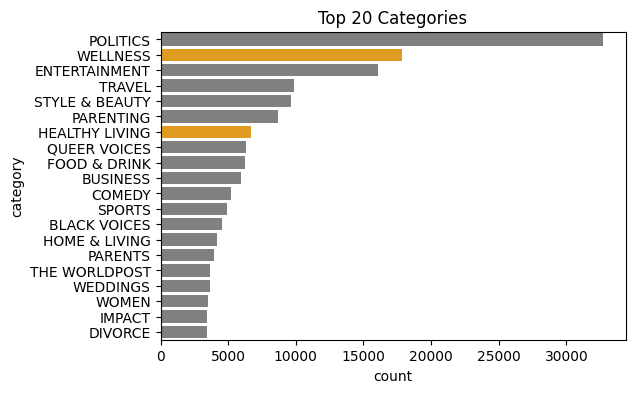

In [13]:
# Create a summary bar chart of categories
f = plt.figure(figsize=(6,4))
cols = ['orange' if (y in ['WELLNESS', 'HEALTHY LIVING']) else 'grey' for y in df_cat_count['category']]
sns.barplot(x = 'count',
            y = 'category',
            data = df_cat_count.head(20),
            palette=cols
            ).set(title='Top 20 Categories',)
plt.show()

In [14]:
# Preview the Split of Data
df_news['wellness'].value_counts()

0    176332
1     24521
Name: wellness, dtype: int64

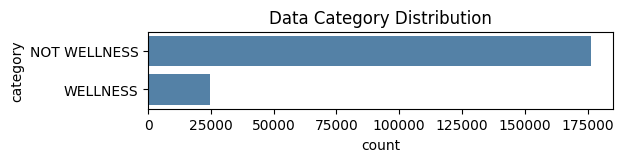

In [15]:
# Create a summary of the categories
df_wellness_count = pd.DataFrame(df_news['wellness'].value_counts()).reset_index()
df_wellness_count.columns = ['category', 'count']
dict_target_names = {0: 'NOT WELLNESS', 1: 'WELLNESS'}
df_wellness_count['category'].replace(dict_target_names, inplace=True)
# Create a summary bar chart of categories
f = plt.figure(figsize=(6,1))
sns.barplot(x = 'count',
            y = 'category',
            data = df_wellness_count,
            color = 'steelblue'
            ).set(title='Data Category Distribution',)
plt.show()

The categories are unevenly distributed across the categories. To ensure a proper mix of articles from each category, a stratified sample should be conducted to maintain the distribution, but scale down the volume of records. An equal number of wellness and non-wellness articles should be included in the sampled data.

## Review of the Text

Text(0, 0.5, 'Record Count')

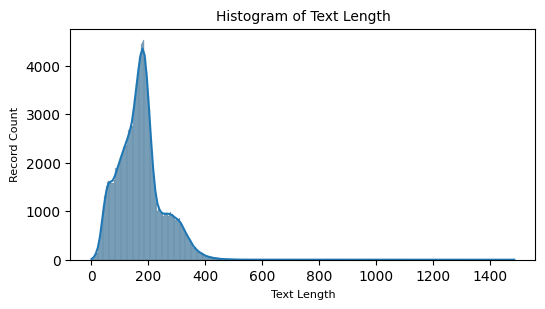

In [16]:
# add a length column to the dataframe
df_news['text_length'] = df_news['combined_text'].apply(len)
#create a figure
fig, ax = plt.subplots(figsize = (6,3))
# create a histogram of the length of text
#chart = plt.hist(x = df_s['Text Length'])
chart = sns.histplot(x = df_news['text_length'], kde=True)
# Customising legend
ax.set_title('Histogram of Text Length', fontsize=10)
ax.set_xlabel('Text Length', fontsize=8)
ax.set_ylabel('Record Count', fontsize=8)

Text(0.5, 1.0, 'Boxplot of Text Length')

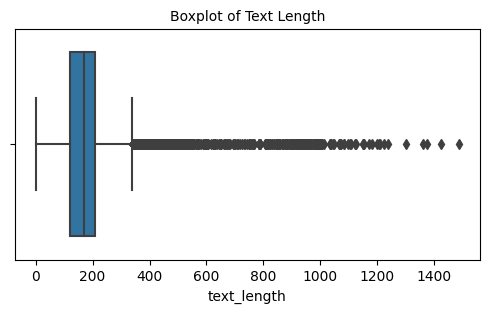

In [17]:
#create a figure
fig, ax = plt.subplots(figsize = (6,3))
# create a boxplot of the length of text
chart = sns.boxplot(x = df_news['text_length'])
ax.set_title('Boxplot of Text Length', fontsize=10)

Text(0.5, 1.0, 'Boxplot of Word Count')

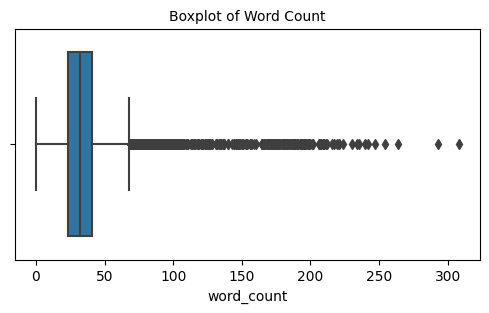

In [18]:
# define a function to add the word count to a dataframe
def add_word_count(df):
    df['text_token'] = df.apply(lambda row: nltk.word_tokenize(row['combined_text']), axis=1)
    df['word_count'] = df['text_token'].apply(len)
    df.drop(columns = ['text_token'], inplace=True)
    return df
# add a length column to the dataframe for wordcount
df_news = add_word_count(df = df_news)
#create a figure
fig, ax = plt.subplots(figsize = (6,3))
# create a boxplot of the length of text
chart = sns.boxplot(x = df_news['word_count'])
ax.set_title('Boxplot of Word Count', fontsize=10)

# 4.&nbsp;Data Cleansing

## Check for Nulls and Remove

In [ ]:
# Inspect observations (rows) with null values
def count_all_rows_with_null(df):
  df_null = df.isnull()
  df_null['null_count'] = df_null.sum(axis=1)
  df_null['null_flag'] = df_null['null_count'].apply(lambda x: 1 if x > 0 else 0)

  df_null = df_null[df_null['null_count'] > 0]
  print('count of observations with nulls:',df_null['null_flag'].sum())

## Clean Text for Modeling

In [19]:
# Create a funtion to clean a dataframe with text
def clean_text(df, text_col):
    # removes punctuation
    df['no_punct'] = df[text_col].apply(
        lambda row: re.sub(r'[^\w\s]+', '', row))
    # removes numbers
    df['no_punct_num'] = df['no_punct'].apply(
        lambda row: re.sub(r'[0-9]+', '', row))
    # removes stop words, e.g. a, an, and, but, in, on, the...
    stop_words = stopwords.words('english')
    df['no_stopwords'] = df['no_punct_num'].apply(
        lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    # removes extra spaces
    df['clean_text'] = df['no_stopwords'].apply(
        lambda x: re.sub(' +', ' ', x))
    # tidy the table
    df.drop(columns = ['no_punct','no_punct_num','no_stopwords'], inplace=True)
    return

In [20]:
# Tokenize text functions
wordnet_lemmatizer = WordNetLemmatizer()
# Function to bulkify lemmatize large block of text one word at a time
def lemmatizer(text):
    lem = [wordnet_lemmatizer.lemmatize(word.lower()) for word in text]
    return lem
# Function to tokenize the entire article then apply the lemmatize to each article
def tokenize_lemmatize(df, text_col):
    df['tokenized_text'] = df.apply(lambda row: nltk.word_tokenize(row[text_col]), axis=1)
    df['lemmatized_text'] = df['tokenized_text'].apply(lambda string: lemmatizer(string))
    return

In [21]:
idx = 0
# Change the text to lowercase
df_news['combined_text'] = df_news['combined_text'].str.lower()
# Using 'clean_text' function to clean 'Text' column
clean_text(df = df_news, text_col = 'combined_text')
# Preview the changes for the before and after text
print(df_news['combined_text'][idx])
print('\n## change to ##\n')
print(df_news['clean_text'][idx])
print('\n--------------------\n')
# Tidy the table
df_news['combined_text'] = df_news['clean_text']
df_news.drop(columns = ['clean_text'], inplace=True)
# Using text cleaning function to clean the text column
tokenize_lemmatize(df = df_news, text_col = 'combined_text')
# Print a before an after of the tokenization and lematization
print(df_news['combined_text'][idx])
print('\n## change to ##\n')
print(df_news['lemmatized_text'][idx])
print('\n--------------------\n')
# Tidy the table
df_news['combined_text'] = df_news.apply(lambda row: ' '.join(row['lemmatized_text']), axis=1)
df_news.drop(columns = ['tokenized_text', 'lemmatized_text'], inplace=True)
# Print a final preview of the text
print('## final text ##\n')
print(df_news['combined_text'][idx])

there were 2 mass shootings in texas last week, but only 1 on tv she left her husband. he killed their children. just another day in america.

## change to ##

mass shootings texas last week tv left husband killed children another day america

--------------------

mass shootings texas last week tv left husband killed children another day america

## change to ##

['mass', 'shooting', 'texas', 'last', 'week', 'tv', 'left', 'husband', 'killed', 'child', 'another', 'day', 'america']

--------------------

## final text ##

mass shooting texas last week tv left husband killed child another day america


## Sample and Balance the Data

In [22]:
# Set a sample amount
sample_amount = 2000
# Sample healthy living
healthy = df_news[df_news['wellness'] == 1].sample(n = sample_amount)
# Sample non-healthy living
not_healthy = df_news[df_news['wellness'] == 0]
not_healthy_rows = len(not_healthy)
not_healthy_sample_frac = sample_amount / not_healthy_rows
not_healthy = not_healthy.groupby('category').apply(
    lambda x: x.sample(frac = not_healthy_sample_frac))
not_healthy = not_healthy.droplevel(0)
# Create a Sampled Dataset
df_news_sample = pd.concat([healthy, not_healthy])
# Preview the Split of Data
print(df_news_sample['wellness'].value_counts(), '\n')
# Confirm all categories are represented
sample_cat_list = list(df_news_sample['category'].unique())
total_sample_cats = len(sample_cat_list)
print('Sample Categories:', total_sample_cats, '\n\tList:', sample_cat_list)

0    2001
1    2000
Name: wellness, dtype: int64 

Sample Categories: 41 
	List: ['HEALTHY LIVING', 'WELLNESS', 'ARTS', 'ARTS & CULTURE', 'BLACK VOICES', 'BUSINESS', 'COLLEGE', 'COMEDY', 'CRIME', 'CULTURE & ARTS', 'DIVORCE', 'EDUCATION', 'ENTERTAINMENT', 'ENVIRONMENT', 'FIFTY', 'FOOD & DRINK', 'GOOD NEWS', 'GREEN', 'HOME & LIVING', 'IMPACT', 'LATINO VOICES', 'MEDIA', 'MONEY', 'PARENTING', 'PARENTS', 'POLITICS', 'QUEER VOICES', 'RELIGION', 'SCIENCE', 'SPORTS', 'STYLE', 'STYLE & BEAUTY', 'TASTE', 'TECH', 'THE WORLDPOST', 'TRAVEL', 'WEDDINGS', 'WEIRD NEWS', 'WOMEN', 'WORLD NEWS', 'WORLDPOST']


In [23]:
# Create a summary of the categories
df_sample_cat_count = pd.DataFrame(df_news_sample['category'].value_counts()).reset_index()
df_sample_cat_count.reset_index()
df_sample_cat_count.columns = ['category', 'count']

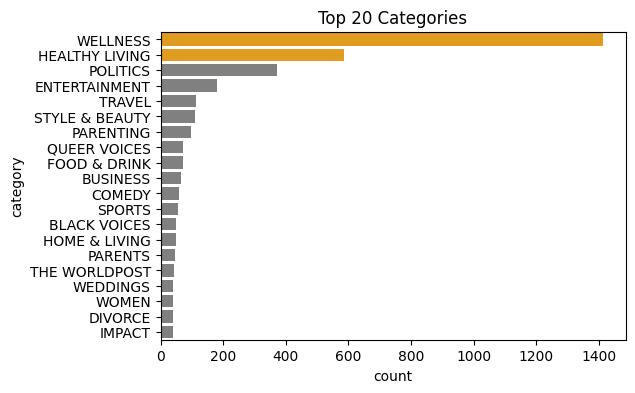

In [24]:
# Create a summary bar chart of categories
cols = ['orange' if (y in ['WELLNESS', 'HEALTHY LIVING']) else 'grey' for y in df_sample_cat_count['category']]
f = plt.figure(figsize=(6,4))
sns.barplot(x = 'count',
            y = 'category',
            data = df_sample_cat_count.head(20),
            palette=cols
            ).set(title='Top 20 Categories')
plt.show()

In [25]:
# Preview the Split of Data
df_news_sample['wellness'].value_counts()

0    2001
1    2000
Name: wellness, dtype: int64

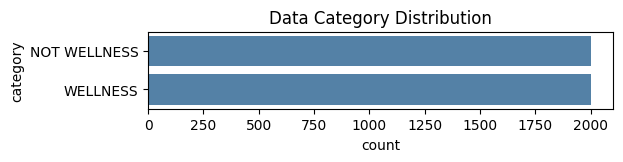

In [26]:
# Create a summary of the categories
df_samp_wellness_count = pd.DataFrame(df_news_sample['wellness'].value_counts()).reset_index()
df_samp_wellness_count.columns = ['category', 'count']
dict_target_names = {0: 'NOT WELLNESS', 1: 'WELLNESS'}
df_samp_wellness_count['category'].replace(dict_target_names, inplace=True)
# Create a summary bar chart of categories
f = plt.figure(figsize=(6,1))
sns.barplot(x = 'count',
            y = 'category',
            data = df_samp_wellness_count,
            color = 'steelblue'
            ).set(title='Data Category Distribution',)
plt.show()

In [29]:
df_news_sample.head(3)

,category,headline,authors,link,short_description,date,combined_text,wellness,text_length,word_count
22301,HEALTHY LIVING,Deconstructing Stigma: Make Your Mental Health...,"McLean Hospital, ContributorThe #1 freestandin...",https://www.huffingtonpost.com/entry/deconstru...,Editor’s note: Deconstructing Stigma: A Change...,2017-07-05,deconstructing stigma make mental health prior...,1,184,33
39800,HEALTHY LIVING,10 Ways To Help Beat The Holiday Blues,"Allison Chawla , ContributorPsychotherapist, L...",https://www.huffingtonpost.com/entry/ten-ways-...,Do what is best for you.,2016-12-16,way help beat holiday blue best,1,63,15
129834,WELLNESS,From Conception to an Olympic Athlete,"Birgitta Lauren, Contributor\nHolistic Materni...",https://www.huffingtonpost.com/entry/from-conc...,Starting athletics well before pregnancy helps...,2014-02-24,conception olympic athlete starting athletics ...,1,163,28


# 5.&nbsp;Model: Parameter Tuning

In [30]:
target_names = ['NOT WELLNESS','WELLNESS']

In [31]:
# create a transformer to use in the model
tf.keras.backend.clear_session()
t = text.Transformer('distilbert-base-uncased',
                     maxlen = 512,
                     class_names = target_names)
# other models you might try 'roberta-base', 'bert-base-uncased', 'distilroberta-base'
# we're going to use 'distilbert-base-uncased' for our model here
# ktrain lets us try some of the pretrained models available on huggingface
# you can browse all the models here: https://huggingface.co/transformers/pretrained_models.html
# some work, some dont, try at your own risk.

In [32]:
# use the distilbert-base-uncased transformer model
# See all the models here: https://huggingface.co/transformers/pretrained_models.html
train, val, preprocess = texts_from_df(df_news_sample, 'combined_text',
                                       label_columns = ['wellness'],
                                       val_df = None,
                                       max_features = 20000,
                                       maxlen = 512,
                                       val_pct = 0.1,
                                       ngram_range = 1,
                                       preprocess_mode = 'distilbert',
                                       verbose = 1)

['not_wellness', 'wellness']
        not_wellness  wellness
75037            1.0       0.0
71254            1.0       0.0
34387            1.0       0.0
93464            0.0       1.0
129452           0.0       1.0
['not_wellness', 'wellness']
        not_wellness  wellness
154084           0.0       1.0
7043             1.0       0.0
186217           0.0       1.0
155277           0.0       1.0
38350            1.0       0.0
preprocessing train...
language: en
train sequence lengths:
	mean : 18
	95percentile : 31
	99percentile : 37


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 18
	95percentile : 30
	99percentile : 36


In [33]:
# create a classifier model
model = preprocess.get_classifier()
# Returns a Learner instance that can be used to tune and train Keras models.
learner = ktrain.get_learner(model,
                             train_data = train,
                             val_data = val,
                             batch_size = 16)

In [34]:
# Simulate training for different learning rates
# Plots loss as learning rate is increased
learner.lr_find(max_epochs = 8)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
225/225 [==============================] - 213s 873ms/step - loss: 0.6872 - accuracy: 0.5608
Epoch 2/6
225/225 [==============================] - 203s 899ms/step - loss: 0.4488 - accuracy: 0.8133
Epoch 3/6
225/225 [==============================] - 201s 892ms/step - loss: 0.4574 - accuracy: 0.7794
Epoch 4/6
225/225 [==============================] - 199s 885ms/step - loss: 0.7072 - accuracy: 0.4939
Epoch 5/6
225/225 [==============================] - 196s 871ms/step - loss: 0.6990 - accuracy: 0.4867
Epoch 6/6
225/225 [==============================] - 136s 603ms/step - loss: 1849.2416 - accuracy: 0.5024


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


Three possible suggestions for LR from plot:
	Longest valley (red): 8.90E-06
	Min numerical gradient (purple): 3.00E-05
	Min loss divided by 10 (omitted from plot): 1.67E-05


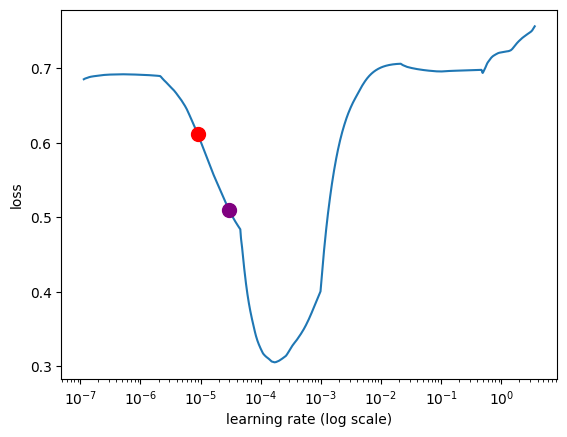

In [37]:
# Plots the loss vs. learning rate to help identify
# The maximal learning rate associated with a falling loss.
learner.lr_plot(suggest = True)

In [36]:
# Return numerical estimates of lr using two different methods:
lr_est = learner.lr_estimate()
print('learning rate (estimate):', lr_est)

learning rate (estimate): (2.9994164e-05, 1.6737992700655015e-05, 8.904907e-06)


based on the learning rate plot, a learning rate of 10^-4 should be used for the final model.

# 6.&nbsp;Final Model with Ktrain

In [44]:
# Automatically train model with the selected learning rate
history = learner.autofit(
    lr = 3e-5,   #1e-4,
    checkpoint_folder = 'checkpoint',
    epochs = 12,
    early_stopping = True)



begin training using triangular learning rate policy with max lr of 3e-05...
Epoch 1/12
225/225 [==============================] - 206s 912ms/step - loss: 0.6932 - accuracy: 0.5039 - val_loss: 0.6931 - val_accuracy: 0.5012
Epoch 2/12
225/225 [==============================] - 202s 898ms/step - loss: 0.6933 - accuracy: 0.4933 - val_loss: 0.6931 - val_accuracy: 0.5012
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


In [ ]:
# Save the learner
#learner.save_model("%s/distilbertmodel_learner" % DATA_DIR)

In [57]:
# Returns a Predictor instance that can be used to make predictions on unlabeled examples
predictor = ktrain.get_predictor(learner.model, preproc = preprocess)
# Save the predictor model
#predictor.save("%s/distilbertmodel_predictor")

In [45]:
# Returns confusion matrix and optionally prints a classification report.
validation = learner.validate(val_data = val,
                              print_report = True,
                              class_names = target_names)

13/13 [==============================] - 3s 85ms/step
              precision    recall  f1-score   support

NOT WELLNESS       0.50      1.00      0.67       201
    WELLNESS       0.00      0.00      0.00       200

    accuracy                           0.50       401
   macro avg       0.25      0.50      0.33       401
weighted avg       0.25      0.50      0.33       401



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 7.&nbsp; Model Evaluation

## Model Metrics

In [46]:
validation

array([[201,   0],
       [200,   0]])

In [48]:
# save confusion matrix and slice into four pieces
TP = validation[1, 1]
TN = validation[0, 0]
FP = validation[0, 1]
FN = validation[1, 0]

In [50]:
c_accuracy            = (TP + TN) / (TP + TN + FP + FN)
c_error               = (FP + FN) / (TP + TN + FP + FN)
c_sensitivity         = TP / (TP + FN)
c_specificity         = TN / (TN + FP)
c_false_positive_rate = FP / (TN + FP)
c_precision           = TP / (TP + FP)

<ipython-input-50-90bab7582182>:6: RuntimeWarning: invalid value encountered in long_scalars
  c_precision           = TP / (TP + FP)


In [53]:
print('Accuracy:\t\t', round(c_accuracy,4)*100, '%')
print('Classification Error:\t', round(c_error,4)*100, '%')
print('Sensitivity / Recall:\t', round(c_sensitivity,4)*100, '%')
print('Specificity:\t\t', round(c_specificity,4)*100, '%')
print('False Positive Rate:\t', round(c_false_positive_rate,4)*100, '%')
print('Precision:\t\t', round(c_precision,4)*100, '%')

Accuracy:		 50.12 %
Classification Error:	 49.88 %
Sensitivity / Recall:	 0.0 %
Specificity:		 100.0 %
False Positive Rate:	 0.0 %
Precision:		 nan %


## Inspecting the drivers of prediction

In [54]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

  Preparing metadata (setup.py) ... done


In [55]:
test_docs = [
'Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.',
'Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.',
'What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.',
'Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.',
'Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney described the woman who said former Gov. Andrew Cuomo had groped her as “credible,” but added that proving her allegation would be difficult.',
'A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust.'
             ]

In [58]:
for i, text in enumerate(test_docs):
  probs = predictor.predict(text, return_proba=True)
  print("---------------------------")
  print('The probability this is healthy is %s' % probs[1])
  print(text)

---------------------------
The probability this is healthy is 0.49925113
Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.
---------------------------
The probability this is healthy is 0.49925113
Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.
---------------------------
The probability this is healthy is 0.49925113
What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.
---------------------------
The probability this is healthy is 0.49925113
Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.
---------------------------
The probability this is healthy is 0.49925113
Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The

In [59]:
predictor.explain('Diversity is the key to a healthy society. Here is what we need to do to make america a more equitable place to live for all.')

/usr/local/lib/python3.10/dist-packages/ktrain/text/predictor.py:139: UserWarning: ktrain requires a forked version of eli5 to support tf.keras. Install with: pip install https://github.com/amaiya/eli5-tf/archive/refs/heads/master.zip
  warnings.warn(msg)


# 8.&nbsp; Results

# 9.&nbsp; References